# Orthogonal Convolutions

The aim of this notebook is to present the main results of the paper: "Long range integration in neural networks with orthogonal convolutions".

It is divided in three main sections corresponding to the three main experiments studied in the paper.
- CIFAR-10
- Receptive fields
- Pathfinder

In each section, the user can load a pre-trained model and evaluate its performance.
A few of the models showed in the paper are available in this repository, one for each set of parameters.
This notebook is intended be used for evaluation only, not for training. 

Note that the code runs on GPU.

When loading a model, the option model="baseline" refers to a standard convolutional network, while model="orthogonal" corresponds to the new proposed architecture. Other parameters corresponds to those explained in the paper: 'depth' is the number of layers, 'kernel' is the kernel size.

### Imports and setting up the environement

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from BilinearInterpolate3D import BilinearInterpolate3D
from OrthogonalConv import NetXCycle
from utils import *
from saliency import *

W0218 14:29:44.440946 140338213074752 deprecation_wrapper.py:119] From /tf/notebooks/sumbission-ICML/KJHYgfOhas/ICML-Submission/OrthogonalConv.py:4: The name tf.keras.initializers.RandomUniform is deprecated. Please use tf.compat.v1.keras.initializers.RandomUniform instead.



In [2]:
# Setting a GPU memory fraction used (if desired) to limit resource usage
# gpu_memory_fraction = 0.4
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)
# tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
# Set larger batch size to speed up evaluation times, or smaller to avoid OOM issues.
BATCH_SIZE = 64

## CIFAR-10

- Load dataset
- Load model
- Show model summary
- Evaluate model

In [4]:
# Set dataset path and load dataset
cifar_dataset_path = 'section_4.1/data/CIFAR-10_test.h5'
x_test, y_test = read_h5_dataset(cifar_dataset_path)

In [5]:
# Load desired model
model = "orthogonal"  # "orthogonal" or "baseline"
depth = 18          # 3, 6, 9, 12, 15 or 18
cifar_model_path = 'section_4.1/models/'+model+'_models/'+model+'_cifar10_depth'+str(depth)+'.h5'
cifar_model = load_model(cifar_model_path, custom_objects={'BilinearInterpolate3D': BilinearInterpolate3D})

W0218 14:29:45.048411 140338213074752 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0218 14:29:45.048885 140338213074752 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0218 14:29:45.051937 140338213074752 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprec

In [6]:
# Print model summary
cifar_model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 80)        2240      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 32, 32, 80)        320       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 80)        0         
_________________________________________________________________
bilinear_interpolate3d (Bili (None, 75, 75, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 75)        50700     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 75, 75, 75)        300 

In [7]:
# Evaluating 
scores = cifar_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

10000/10000 [==============================] - 9s 895us/sample - loss: 0.4911 - acc: 0.8815


## Receptive fields plots
- Load and scale a sample image
- Choose layer list and number of nodes to sample
- Plot receptive field

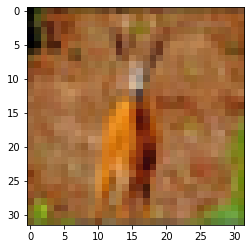

In [8]:
# Load and scale a sample image at random
image_index = np.random.randint(0, x_test.shape[0]-1)
image = x_test[image_index]
plt.imshow((image * NORMALIZING_CONST + CENTRALIZING_CONST)/QUANTIZATION_SIZE)

Choose two layers to visualize the receptive field.

Default is:
- After first convolution (layer number = 1)
- After last cycle (layer number = 15+(depth/3-1)*16)

Change numbers in 'layer_list' to visualize receptive fields in other layers.
Add more elements to 'layer_list' to visualize more layers.

'no_of_nodes' is the number of neurons for which the receptive field is visualized, in each layer. 

In [9]:
# Choose layer list and number of nodes to sample
no_of_nodes = 3
layer_list = [1, int(15+(depth/3-1)*16)]   # Add instructions on which layer is being checked
saliency = get_saliency_maps_and_fitted_ellipses(cifar_model, layer_list, no_of_nodes, image)

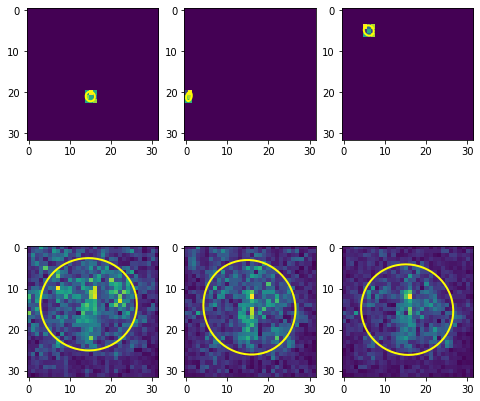

In [10]:
# Plot receptive field. If a node is deactivated, a blank image will be displayed.
print_images(*saliency)

## Receptive fields stats
- Choose a layer (default is last cycle), number of nodes and images to sample.
- Compute and display receptive field statistics. Deactivated nodes do not participate in the statistics.

The output displays the mean and standard deviation of the receptive field size.

In [11]:
# Set variables controlling layer number, number of images, number of nodes and image indices.
layer = int(15+(depth/3-1)*16)
no_of_images = 2
no_of_nodes = 2
image_indices = np.random.randint(0, x_test.shape[0]-1, size=no_of_images)

In [12]:
# Compute statistics 
sqrt_traces = get_saliency_stats(cifar_model, layer, no_of_nodes, x_test[image_indices])
print("Mean:", np.mean(sqrt_traces))
print("Std:", np.std(sqrt_traces))

Mean: 11.531519338421836
Std: 0.30995449325088803


## Pathfinder

The orginal test dataset included 100000 images, following the test-training split of the original pathfinder paper https://arxiv.org/abs/1805.08315. To prevent possible memory problems that the user my encounter while loading the data, here we provide a subset of 10000 random images of the test data employed for the evaluation. 

- Load dataset
- Load model from a directory
- (Optional) For large models of kernel size 20, run a script to untar and reconstruct the model.
- Load model
- Show model summary
- Evaluate model

'length' refers to the the path lengths of the pathfinder dataset (see paper)

In [13]:
model = "orthogonal"    # "orthogonal" or "baseline"
length = 9              # 6, 9 or 14
kernel = 8              # 4, 8, 12 or 20

In [14]:
pathfinder_dataset_path = 'section_4.5/data/pathfinder_path'+str(length)+'_test.h5'
x_test, y_test = read_h5_dataset(pathfinder_dataset_path, scale = False)

In [15]:
# Specify the model path (either directory or h5 file) - no trailing `/` for kernel size 20, otherwise the .h5 file directly
pathfinder_model_path = 'section_4.5/models/'+model+'_models/'+model+'_pathfinder'+str(length)+'_kernelsize'+str(kernel)

# Identify if the path given identifies a h5 file or a directory requiring untarring
# If untarring required, extract model and update model path to extracted h5 file
if kernel==20:
    !sh untar.sh $pathfinder_model_path
    a = !ls $pathfinder_model_path
    model = [i for i in a if i.find('.h5') != -1][0]
    pathfinder_model_path = pathfinder_model_path + '/' + model
else:
    pathfinder_model_path += '.h5'

In [16]:
# Load model
pathfinder_model = load_model(pathfinder_model_path, custom_objects={'BilinearInterpolate3D':BilinearInterpolate3D,
                                                                     'NetXCycle': NetXCycle})
# Remove extracted model file if required
if kernel==20:
    !rm $pathfinder_model_path

W0218 14:30:19.476672 140338213074752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
# Print model summary
pathfinder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     8320      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 128, 128, 128)     512       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 128)     0         
_________________________________________________________________
net_x_cycle (NetXCycle)      (None, 128, 128, 128)     3147648   
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0     

Note that the orthogonal convolution cycle is defined expicitly for the CIFAR models. 'model.summary()' shows the sequence of convolution and permutations; for the pathfinder models, instead, the cycles are wrapped using a "NetXCycle" layer. The CIFAR models are defined explicitly to allow computing the receptive fields at different stages.

In [18]:
# Evaluating 
scores = pathfinder_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

10000/10000 [==============================] - 23s 2ms/sample - loss: 0.2660 - acc: 0.8902
